# **Baseline models**

### **Table of contents**

1. Introduction
2. Load and Check Data
    - Split into train and test
3. Series Stationarity
    - Augmented Dickey-Fuller (ADF)
4. Error Metrics
5. Mean Baseline Model
6. Moving Average Baseline Model
7. Data Save for Modeling

#### **1. Introduction**

In this notebook, we will develop two basic baseline models that will serve as a reference to surpass. Baseline models are useful to assess whether our models provide a significant advantage in the forecasting task. If our model only slightly outperforms or performs worse than the baseline model, it may be more effective to utilize the baseline and abandon the alternative modeling approach.

For our baseline models, we will employ a simple mean approach by calculating the average of the nd column. In other words, our best estimate at any given point in time is that the temperature is equivalent to the overall average temperature.

The other baseline model involves calculating the rolling average of the three previous periods. This method smooths the data, resulting in reduced abrupt changes. This model is also considered simple because the sole criterion for determining the next point is the average of the preceding values.

While these models may seem simplistic, they will be valuable for evaluating our subsequent models.

### **2. Load and check data**

In [1]:
#Import all relevant libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

from scipy import stats
from statsmodels.api import tsa
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import plotly.graph_objs as go

In [2]:
#read csv and make firts column the index 
df = pd.read_csv('../data/historic_demand_2009_2023_prepro.csv', index_col=0)
df_monthly = pd.read_csv('../data/monthly_historic_demand_2009_2023_prepro.csv', index_col=0)

In [3]:
#Change index
df = df.set_index(pd.to_datetime(df.index))
df_monthly = df_monthly.set_index(pd.to_datetime(df_monthly.index))

print(f"Index data type of df is: {type(df.index)}")
print(f"Index data type of df_monthly is: {type(df_monthly.index)}")

Index data type of df is: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index data type of df_monthly is: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [4]:
#Check load
df_monthly.head()

,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,is_holiday,import_export,trend_nd,seasonal_nd,residual_nd
settlement_date,,,,,,,,,,,,,,,
2009-01-01,36456,63238939,65701420,57084786,884444,2087664,0,0,2715,641445,48,-31262,NaN,8.907491e+06,NaN
2009-02-01,32928,56073378,58219109,50568667,605475,1888320,0,0,2547,661261,0,154235,NaN,2.950784e+06,NaN
2009-03-01,36361,56519297,58744931,50990231,1006838,2108634,0,0,4226,658593,0,357878,NaN,4.454625e+06,NaN
2009-04-01,35280,49311414,50811309,44476006,661797,2322332,0,0,0,355152,96,1465087,NaN,-2.408486e+06,NaN
2009-05-01,36456,48437067,50066762,43757738,1096316,2489304,0,0,9328,554994,96,2240639,NaN,-4.072485e+06,NaN


#### **Split into Train and Test**

For the split into the train and test sets, we will divide the data into a train group consisting of 80% of the data points and a test group consisting of 20% of the dataset. We will create separate train and test sets for the original data, as well as for the differenced data. This differentiation is necessary for certain models.

In [5]:
#Create seasonal difference column
df_monthly['diff_1_year'] = df_monthly['nd'].diff(12) #One year diff, 12 months

In [6]:
#Determine 80-20 split
print(len(df.index)*.8)
print(df.index[198467])

198467.2
2020-05-13 05:30:00


In [8]:
#Create train and test and drop the null values introduced at differencing
train_diff = df_monthly.loc[df_monthly.index <= "2020-05-13", 'diff_1_year'].dropna()
test_diff = df_monthly.loc[df_monthly.index > "2020-05-13", 'diff_1_year']

train = df_monthly.loc[df_monthly.index <= "2020-05-13", 'nd']
test = df_monthly.loc[df_monthly.index > "2020-05-13", 'nd']

In [9]:
print(train_diff.shape)
print(test_diff.shape)
print(train.shape)
print(test.shape)

(125,)
(32,)
(137,)
(32,)


### **3. Series stationarity**

A time series is considered stationary if its statistical properties do not change over time. This means that it has a constant mean and variance, while the covariance is independent of time. Stationarity is beneficial for certain models as it allows them to forecast without needing to account for the seasonality, trend, or any exogenous variables present in the series.

The `diff_1_year` column is designed to make the series stationary by subtracting the value from one year before. For example, the value for January 2023 is calculated by subtracting the value from January 2022. This eliminates seasonality from the data.

To illustrate this concept, we have the plot below. The blue line represents the original data, which exhibits a trend (shown by the red trend line) and clear seasonality. The orange line represents the diff_1_year data, which shows no apparent trend, and its variation does not seem to follow any seasonal pattern. This concept was already observed in the EDA notebook through the decomposition of the series, particularly with the "residual" component (represented by the green line in the plot).


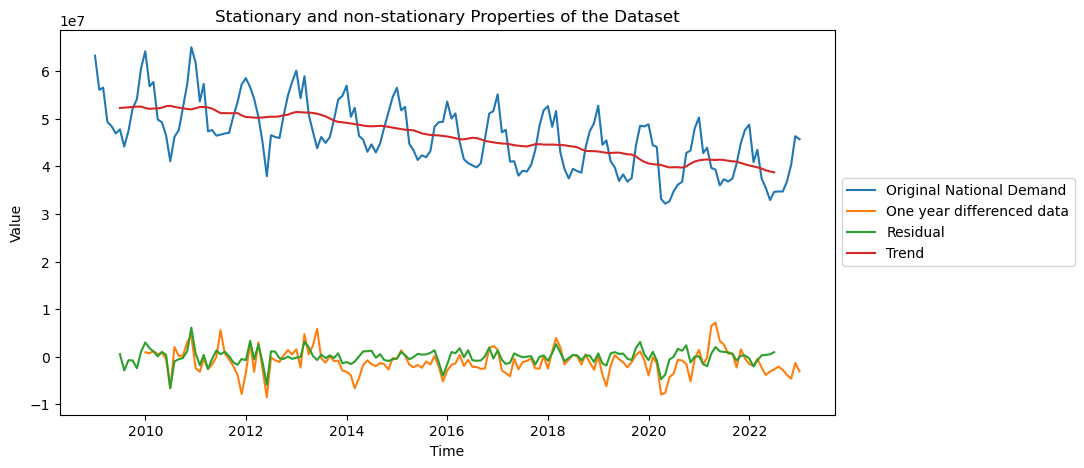

In [10]:
#Ilustrative plot to understand stationary properties of a dataset. 
plt.figure(figsize=(10, 5))
plt.plot(df_monthly['nd'], label='Original National Demand')
plt.plot(df_monthly['diff_1_year'], label='One year differenced data')
plt.plot(df_monthly['residual_nd'], label='Residual')
plt.plot(df_monthly['trend_nd'], label='Trend')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Stationary and non-stationary Properties of the Dataset')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

#### **ADF Test**

To statistically assess and test the stationarity of the series, we will use the Augmented Dickey-Fuller (ADF) test. The ADF test is employed to determine the stationarity of a time series. This test is a crucial step for autoregressive models, as they assume that the time series being fitted is stationary.

The ADF test is an statistical test, therefore, the hypothesis of the test are: 

$$
H_0: \text{The time series is non-stationary.}
$$

$$
H_1: \text{The time series is stationary.}
$$
Siginificance level: 0.05

In [11]:
#Run ADF test on original data. 
adfuller_result = adfuller(df_monthly['nd'], autolag='AIC')
print(f"AD Statistic: {adfuller_result[0]}")
print(f"p-value for ADF test: {adfuller_result[1]}")

AD Statistic: -0.014319665714155615
p-value for ADF test: 0.9573317168372529


From the p-value of the first ADF test we are not able to reject the null hypothesis, this means (as expected) that the series is non-stationary. 

However, if we lag the series by a perdior (month) applying the .diff() method, the data becomes stationary: 

In [12]:
#Apply .diff of one period to make the series statical 
adfuller_result_2 = adfuller(df_monthly['nd'].diff().dropna(), autolag='AIC')
print(f"AD Statistic: {adfuller_result_2[0]}")
print(f"p-value for ADF test: {adfuller_result_2[1]}")

AD Statistic: -5.203446445651966
p-value for ADF test: 8.650752533905518e-06


The low p-value for the test allows us to reject the null hypothesis and conclude that the series is not non-stationary. 

### **4. Error Metrics**

Before evaluating our models, we need to determine the error metrics that we will use for comparison: the Mean Absolute Percentage Error (MAPE) and the Mean Absolute Error (MAE).

These two metrics provide information at different levels. The MAPE gives us a percentage, which is easily understood and is not influenced by the scale of the data. This metric allows us to assess the relative accuracy of our models. On the other hand, the MAE gives us a value in terms of megawatts (MW), which may be more challenging to grasp but is highly relevant and actionable for stakeholders such as energy producers and distributors.

The results will be obtained by comparing the performance of each model on the train and test datasets.

To calculate these metrics, we will use the following functions.

In [19]:
def mean_absolute_percentage_error(true_values, predicted_values):
    """
    Calculate the mean absolute percentage error given the true and predicted values. 
    Find the prediction error and divide by the true value. 
    Then average and multiply by a 100.
    """
    error = true_values - predicted_values
    absolute_percentage_error = np.abs(error/true_values)
    mape = absolute_percentage_error.mean() * 100
    
    return mape

In [20]:
def mean_absolute_error(true_values, predicted_values):
    """
    Calculate the mean absolute error given the true and predicted values. 
    Find the absolute error between true and predicted values, then average.
    """
    error = np.abs(true_values - predicted_values)
    mae = error.mean()

    return mae

The results will be presented in the following df:

In [13]:
models = ['Simple_Mean', 'Rolling_AVG', 'ARIMA', 'SARIMA', 'SARIMAX']
train_mape_values = [0, 0, 0, 0, 0]
test_mape_values = [0, 0, 0, 0, 0]
train_mae_values = [0, 0, 0, 0, 0]
test_mae_values = [0, 0, 0, 0, 0]

data = {
    'model': models,
    'Train_MAPE': train_mape_values,
    'Test_MAPE': test_mape_values,
    'Train_MAE': train_mae_values,
    'Test_MAE': test_mae_values}

results = pd.DataFrame(data)

results

,model,Train_MAPE,Test_MAPE,Train_MAE,Test_MAE
0,Simple_Mean,0,0,0,0
1,Rolling_AVG,0,0,0,0
2,ARIMA,0,0,0,0
3,SARIMA,0,0,0,0
4,SARIMAX,0,0,0,0


### **5. Mean Baseline model**

The mean baseline model will be calculated using differenced data with twelve-month intervals (`diff_1_year`). This differencing process transforms the series into a stationary one, removing the effects of seasonality and trend. However, the results of the model will be reconstructed to present them against the original data for better interpretation and comparison.

In [14]:
#Baseline model of the mean using differences data (train_diff and test_diff)

full_index = pd.concat([train_diff, test_diff]).index
base_line_mean = np.full(full_index.shape, np.mean(train_diff))
mean_predictions = pd.Series(data=base_line_mean, index=full_index)

In the previous block code we are first stablishing the `full_index` by combining the indices of the `train_diff` and `test_diff` datasets. This ensures that the index of the `mean_predictions` matches the index of the combined data.Then we store the  mean value of the `train_diff` dataset using np.mean(train_diff) in the variable `base_line_mean`. This mean value will be used as the prediction for all data points. Finally in the `mean_predictions` we create a pandas Series  with the same shape as the full_index and fill it with the mean value calculated in the previous step. The index of this series is the `full_index`, to ensure alignment with the original data.

In [15]:
#Visualize mean baseline model
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_diff.index, y=train_diff, mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test_diff.index, y=test_diff, mode='lines', name="Test"))

mean_prediction_dates = df_monthly.index[df_monthly.index >= "2020-05-13"]  # Filter mean prediction dates
mean_prediction_values = mean_predictions  # Filter mean prediction values

fig.add_trace(go.Scatter(x=full_index, y=mean_prediction_values, mode='lines', name="Mean Prediction"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="MW", 
    xaxis_title="Date",
    title={'text': '<b>Differenced (12) monthly National Demand and Mean<b>', 'x': 0.5, 'xanchor': 'center'}
)
fig.show()

#### **Reconstruct mean baseline predictions**

The predictions made with the mean baseline model are based on the differenced data, which makes it impossible to directly compare them with the original data. In order to evaluate the baseline mean predictions against the original target variable, we need to reconstruct them by adding the predictions to the original data. This can be done by creating a new column using the `.shift()` method with a 12-period input.

In [16]:
#Create prediction column 
df_monthly['mean_predict'] = df_monthly['nd'].shift(12) + mean_predictions

In [17]:
#Visualize predictions against the original data
fig = go.Figure()

fig.add_trace(go.Scatter(x=train.index, y=train, name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test, name="Test"))
fig.add_trace(go.Scatter(x=test.index, y=df_monthly.loc[test.index, 'mean_predict'], name="Mean prediction"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    title={
        'text': "<b>ND reconstructed mean prediction<b>",
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',},
    yaxis_title="MW"
)

fig.show()

Form the plot above we can see that the predicions follow the figure of the original data but with a 12 month shift. This is because the model was fitted using the difference in values with a 12 month difference (.diff(12)).

#### **Simple mean results**

In [21]:
#Calculate error on mean baseline using original data (train, test)
mean_train_mape = mean_absolute_percentage_error(train, df_monthly.loc[train.index, 'mean_predict'])
mean_test_mape = mean_absolute_percentage_error(test, df_monthly.loc[test.index, 'mean_predict'])
mean_train_mae = mean_absolute_error(train, df_monthly.loc[train.index, 'mean_predict'])
mean_test_mae = mean_absolute_error(test, df_monthly.loc[test.index, 'mean_predict'])

#Print resultas
print(f"Mean baseline Train MAE: {round(mean_train_mae)}")
print(f"Mean baseline Test MAE: {round(mean_test_mae)}")
print(f"Mean baseline Train MAPE: {round(mean_train_mape, 2)}%")
print(f"Mean baseline Test MAPE: {round(mean_test_mape, 2)}%")

Mean baseline Train MAE: 1867551
Mean baseline Test MAE: 2126467
Mean baseline Train MAPE: 3.96%
Mean baseline Test MAPE: 5.49%


From the blocks above we see that the mean model for the test set is on average 2,064,288 MW appart from any given prediction and 5.33% in percentage terms. 


In [22]:
#Append the results in the resulst dataframe
results.loc[results['model'] == 'Simple_Mean', 'Train_MAE'] = mean_train_mae
results.loc[results['model'] == 'Simple_Mean', 'Test_MAE'] = mean_test_mae
results.loc[results['model'] == 'Simple_Mean', 'Train_MAPE'] = mean_train_mape
results.loc[results['model'] == 'Simple_Mean', 'Test_MAPE'] = mean_test_mape

results

,model,Train_MAPE,Test_MAPE,Train_MAE,Test_MAE
0,Simple_Mean,3.957661,5.488195,1.867551e+06,2126466.934
1,Rolling_AVG,0.000000,0.000000,0.000000e+00,0.000
2,ARIMA,0.000000,0.000000,0.000000e+00,0.000
3,SARIMA,0.000000,0.000000,0.000000e+00,0.000
4,SARIMAX,0.000000,0.000000,0.000000e+00,0.000


### **6. Moving Average Baseline Model**

As a second baseline model, we will calculate a Moving Average using a shift of three periods. This means that the model will calculate the mean of the previous three observations.

In [23]:
#Rolling AVG baselinemodel
rolling_AVG = df_monthly['nd'].rolling(3).mean()
base_line_avg = np.full(full_index.shape, rolling_AVG.iloc[-1])
AVG_predictions = pd.Series(data=base_line_avg, index=full_index)

In the previous codeblock we in the `rolling_AVG` variable we are calculating the rolling average of the `nd`, this rolling average is computed over a window size of 3, which means it takes the average of the current data point and the two preceding data points. The `base_line_avg` variable stores an array of the same shape as the `full_index` (used in the simple mean baseline model) initialized with the value of the last element of the `rolling_AVG`. This value represents the average prediction for all data points. And in `AVG_predictions` we create a pandas Series with the same shape as the full_index and fills it with the average value obtained in the previous step.

In [24]:
#Add a column to the original df
df_monthly['rolling_avg'] = df_monthly['nd'].rolling(3).mean()
df_monthly['rolling_avg']

settlement_date
2009-01-01             NaN
2009-02-01             NaN
2009-03-01    5.861054e+07
2009-04-01    5.396803e+07
2009-05-01    5.142259e+07
                  ...     
2022-09-01    3.469063e+07
2022-10-01    3.539587e+07
2022-11-01    3.725628e+07
2022-12-01    4.113075e+07
2023-01-01    4.410807e+07
Name: rolling_avg, Length: 169, dtype: float64

In [25]:
#Plot rolling average predictions
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_monthly.index, y=df_monthly['nd'], mode='lines', name='Original'))
fig.add_trace(go.Scatter(x=test.index, y=test, name="Test"))
fig.add_trace(go.Scatter(x=test.index, y=df_monthly.loc[test.index, 'rolling_avg'], mode='lines', name='3-Months Rolling Average'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='nd',
    title={'text': '<b>Original Time Series and 3-Months Rolling Average<b>', 'x': 0.5, 'xanchor': 'center'})
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(showlegend=True)

fig.show()

From the plot above we can see, as expected, that the rolling average model imitates the original trend with some lag and with smooth lines; notice how the rolling average does not have the bumps of the test set.  

In [26]:
#Store and print results
AVG_train_mape = mean_absolute_percentage_error(df_monthly.loc[train.index,'nd'], df_monthly.loc[train.index,'rolling_avg'])
AVG_test_mape = mean_absolute_percentage_error(df_monthly.loc[test.index,'nd'], df_monthly.loc[test.index,'rolling_avg'])
AVG_train_mae = mean_absolute_error(df_monthly.loc[train.index,'nd'], df_monthly.loc[train.index,'rolling_avg'])
AVG_test_mae = mean_absolute_error(df_monthly.loc[test.index,'nd'], df_monthly.loc[test.index,'rolling_avg'])

print(f"Train MAPE - Rolling Average: {round(AVG_train_mape, 2)}%")
print(f"Test MAPE - Rolling Average: {round(AVG_test_mape, 2)}%")
print(f"Train MAE - Rolling Average: {round(AVG_train_mae, 2)}")
print(f"Test MAE - Rolling Average: {round(AVG_test_mae, 2)}")

Train MAPE - Rolling Average: 5.31%
Test MAPE - Rolling Average: 5.14%
Train MAE - Rolling Average: 2520437.6
Test MAE - Rolling Average: 2122838.04


In [27]:
#Append rolling average results
results.loc[results['model'] == 'Rolling_AVG', 'Train_MAE'] = AVG_train_mae
results.loc[results['model'] == 'Rolling_AVG', 'Test_MAE'] = AVG_test_mae
results.loc[results['model'] == 'Rolling_AVG', 'Train_MAPE'] = AVG_train_mape
results.loc[results['model'] == 'Rolling_AVG', 'Test_MAPE'] = AVG_test_mape
results

,model,Train_MAPE,Test_MAPE,Train_MAE,Test_MAE
0,Simple_Mean,3.957661,5.488195,1.867551e+06,2.126467e+06
1,Rolling_AVG,5.310872,5.135859,2.520438e+06,2.122838e+06
2,ARIMA,0.000000,0.000000,0.000000e+00,0.000000e+00
3,SARIMA,0.000000,0.000000,0.000000e+00,0.000000e+00
4,SARIMAX,0.000000,0.000000,0.000000e+00,0.000000e+00


Both of our baseline models performed similarly in the test set. The Rolling Average model performed slightly worse in the train set compared to the test set. In general, the conclusion is that the predictions made by these models deviate from the real values by approximately 5.13% to 5.48%.

The following visualization showcases how these models performed compared to the test set.

In [32]:
#Plot rolling average predictions
fig = go.Figure()

fig.add_trace(go.Scatter(x=test.index, y=test, name="Test", line=dict(dash='dot')))
fig.add_trace(go.Scatter(x=test.index, y=df_monthly.loc['rolling_avg'], mode='lines', name='3-Months Rolling Average'))
fig.add_trace(go.Scatter(x=test.index, y=df_monthly.loc[test.index, 'mean_predict'], mode='lines', name='Mean predict'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='nd',
    title={'text': '<b>Original Time Series and 3-Months Rolling Average<b>', 'x': 0.5, 'xanchor': 'center'})
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(showlegend=True)

fig.show()

### **7. Data Save for Modeling**

In [29]:
#Save df for modeling
df.to_csv('../data/historic_demand_2009_2023_modeling.csv', index=True)
df_monthly.to_csv('../data/monthly_historic_demand_2009_2023_modeling.csv', index=True)

#Save results for modeling
results.to_csv('../data/results.csv', index=True)

In [30]:
print(df_monthly.shape)
print(train.shape)
print(test.shape)

(169, 18)
(137,)
(32,)


In [36]:
df_monthly.columns

Index(['settlement_period', 'nd', 'tsd', 'england_wales_demand',
       'embedded_wind_generation', 'embedded_wind_capacity',
       'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor',
       'pump_storage_pumping', 'is_holiday', 'import_export', 'trend_nd',
       'seasonal_nd', 'residual_nd', 'diff_1_year', 'mean_predict',
       'rolling_avg'],
      dtype='object')

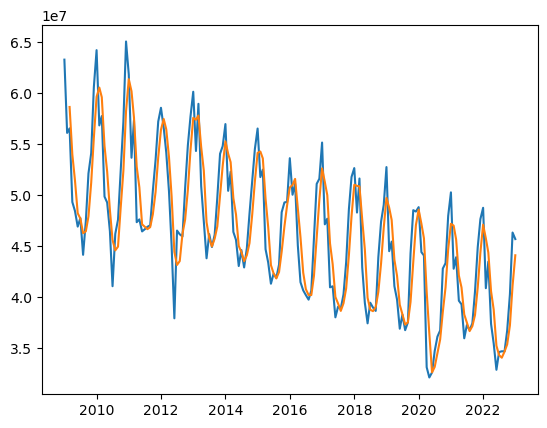

In [38]:
plt.plot(df_monthly['nd'])
plt.plot(df_monthly['rolling_avg'])

In [41]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_monthly.index, y=df_monthly['nd'], name="Test", line=dict(dash='dot')))
fig.add_trace(go.Scatter(x=df_monthly.index, y=df_monthly['rolling_avg'], mode='lines', name='3-Months Rolling Average'))


fig.update_layout(
    xaxis_title='Date',
    yaxis_title='National Demand MW',
    title={'text': '<b>Original Time Series and 3-Months Rolling Average<b>', 'x': 0.5, 'xanchor': 'center'})
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(showlegend=True)

fig.show()